In [54]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
ny_crime = pd.read_csv('/Users/tongzhang/Downloads/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.csv')
ny_crime.columns = ['City', 'Population','Voilent crime','Murder','Rape_revised','Rape_lagacy','Robbery','Assault','Property crime','Burglary','Theft','Motor vehicle theft','Arson']
ny_crime.head()

,City,Population,Voilent crime,Murder,Rape_revised,Rape_lagacy,Robbery,Assault,Property crime,Burglary,Theft,Motor vehicle theft,Arson
0,Adams Village,"1,861",0,0,NaN,0,0,0,12,2,10,0,0.0
1,Addison Town and Village,"2,577",3,0,NaN,0,0,3,24,3,20,1,0.0
2,Akron Village,"2,846",3,0,NaN,0,0,3,16,1,15,0,0.0
3,Albany,"97,956",791,8,NaN,30,227,526,"4,090",705,"3,243",142,NaN
4,Albion Village,"6,388",23,0,NaN,3,4,16,223,53,165,5,NaN


526
8396126
40037.63218390805


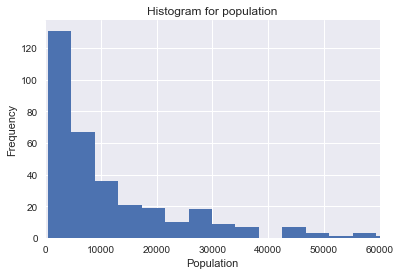

In [77]:
features = ny_crime.copy()
features['Population'] = features['Population'].str.replace(',', '')
features['Population'] = pd.to_numeric(features['Population'])
print(features['Population'].min())
print(features['Population'].max())
print(features['Population'].mean())

plt.hist(features['Population'],bins=2000)

plt.title("Histogram for population")
plt.xlabel("Population")
plt.ylabel("Frequency")
plt.xlim([0,60000])

plt.show()

In [78]:

features['binary_murder']=np.where(ny_crime['Murder'] !=0, 1, 0)
features['binary_Robbery']=np.where(ny_crime['Robbery'] !=0, 1, 0)
features['population_square']=features['Population']*features['Population']
features['Property crime'] = features['Property crime'].str.replace(',', '')
features['Property crime'] = pd.to_numeric(features['Property crime'])


In [80]:
regr = linear_model.LinearRegression()
Y = property_crime.values.reshape(-1, 1)
X = features[['Population','population_square','binary_murder','binary_Robbery']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))




Coefficients: 
 [[  3.42007759e-02  -2.05708444e-09  -9.55478272e+00   0.00000000e+00]]

Intercept: 
 [-156.63730133]

R-squared:
0.996092290373


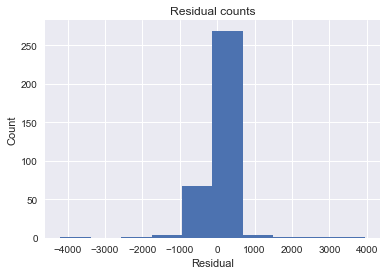

In [81]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = features['Property crime']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

In [ ]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [84]:
from IPython.display import display
correlation_matrix = X.corr()
display(correlation_matrix)

,Population,population_square,binary_murder,binary_Robbery
Population,1.000000,0.998264,0.162309,NaN
population_square,0.998264,1.000000,0.133067,NaN
binary_murder,0.162309,0.133067,1.000000,NaN
binary_Robbery,NaN,NaN,NaN,NaN


The correlation between population and population_square is high, so remove a veriable between these two might be a better option.
Question: How to see if above two graphs violetes the assumption?

In [89]:
# U2L5P2 Challenge: Validating a linear regression
features=features.rename(columns = {'Property crime':'Property_crime'})
features.head()

,City,Population,Voilent crime,Murder,Rape_revised,Rape_lagacy,Robbery,Assault,Property_crime,Burglary,Theft,Motor vehicle theft,Arson,binary_murder,binary_Robbery,population_square
0,Adams Village,1861,0,0,NaN,0,0,0,12,2,10,0,0.0,0,1,3463321
1,Addison Town and Village,2577,3,0,NaN,0,0,3,24,3,20,1,0.0,0,1,6640929
2,Akron Village,2846,3,0,NaN,0,0,3,16,1,15,0,0.0,0,1,8099716
3,Albany,97956,791,8,NaN,30,227,526,4090,705,"3,243",142,NaN,1,1,9595377936
4,Albion Village,6388,23,0,NaN,3,4,16,223,53,165,5,NaN,0,1,40806544


In [94]:
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Write out the model formula.
# Your dependent variable on the right, independent variables on the left
# Use a ~ to represent an '=' from the functional form
linear_formula = 'Property_crime ~ Population+population_square+binary_murder+binary_Robbery'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=features).fit()

In [95]:
lm.params

Intercept           -7.831865e+01
Population           3.420078e-02
population_square   -2.057084e-09
binary_murder       -9.554783e+00
binary_Robbery      -7.831865e+01
dtype: float64

In [96]:
lm.pvalues

Intercept            3.722997e-07
Population           3.596088e-99
population_square    5.572292e-41
binary_murder        9.122439e-01
binary_Robbery       3.722997e-07
dtype: float64

In [97]:
lm.rsquared

0.99609229037258162

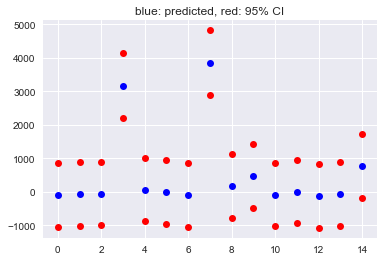

In [98]:
# Use wls_prediction_std to build confidence intervals
prstd, iv_l, iv_u = wls_prediction_std(lm)

plt.figure()
plt.plot(iv_u[0:15], 'o', color='r')
plt.plot(iv_l[0:15], 'o', color='r')
plt.plot(lm.fittedvalues[0:15], 'o', color='b')
plt.title('blue: predicted, red: 95% CI')
plt.show()